# Problem Set 1: "Building a Strategic Portfolio"

In [121]:
# import packages
import pandas as pd
import numpy as np
import yfinance
import matplotlib.pylab as plt
import scipy.stats
import statsmodels.api as sm
from datetime import date

In [122]:
# get data from yfiance

#ydata = yfinance.download(['AAPL', 'MSFT', 'TSLA', 'ORSTED.CO', 'V', '^GSPC'], interval='1mo')['Close'].dropna().to_csv('data.csv')

[*********************100%***********************]  6 of 6 completed


In [123]:
# load data from csv file

data = pd.read_csv('data.csv', index_col=['Date'], date_format=['Date'])

data.head()

,AAPL,MSFT,ORSTED.CO,TSLA,V,^GSPC
Date,,,,,,
2016-06-01,21.849648,45.602211,210.907028,14.152000,69.670097,2098.860107
2016-07-01,23.817484,50.512680,237.851837,15.652667,73.314705,2173.600098
2016-08-01,24.249453,51.207790,232.322464,14.134000,75.991798,2170.949951
2016-09-01,25.977861,51.652515,241.362579,13.602000,77.817390,2168.270020
2016-10-01,26.090462,53.732944,235.833206,13.182000,77.638611,2126.149902


In [124]:
# get log-return

ticker = ['AAPL', 'MSFT', 'TSLA', 'ORSTED.CO', 'V']

for i in range(len(ticker)):
    data.loc[:, "logreturn_" + ticker[i]] = np.log(data[ticker[i]]) - np.log(data[ticker[i]].shift())

In [125]:
# drop nan

data = data.dropna()

data.head()

,AAPL,MSFT,ORSTED.CO,TSLA,V,^GSPC,logreturn_AAPL,logreturn_MSFT,logreturn_TSLA,logreturn_ORSTED.CO,logreturn_V
Date,,,,,,,,,,,
2016-07-01,23.817484,50.512680,237.851837,15.652667,73.314705,2173.600098,0.086235,0.102268,0.100785,0.120231,0.050990
2016-08-01,24.249453,51.207790,232.322464,14.134000,75.991798,2170.949951,0.017974,0.013667,-0.102058,-0.023522,0.035864
2016-09-01,25.977861,51.652515,241.362579,13.602000,77.817390,2168.270020,0.068851,0.008647,-0.038366,0.038174,0.023740
2016-10-01,26.090462,53.732944,235.833206,13.182000,77.638611,2126.149902,0.004325,0.039487,-0.031365,-0.023175,-0.002300
2016-11-01,25.396488,54.037849,210.204865,12.626667,72.755028,2198.810059,-0.026959,0.005658,-0.043041,-0.115042,-0.064967


# Jarque-Bera test for normality

In [126]:
# JB test statistic

JB = np.zeros((len(ticker)))

for i in range(len(ticker)):
    S = scipy.stats.skew(data["logreturn_" + ticker[i]])
    K = scipy.stats.kurtosis(data["logreturn_" + ticker[i]], fisher=False)
    N = data.shape[0]
    JB[i] = (N / 6) * (S**2 + 0.25 * (K - 3)**2)


JB

array([1.69237043, 0.34975399, 1.65410303, 5.61225132, 1.29151882])

In [127]:
# Chi-squared distribution

cdf = np.zeros((len(ticker)))

for i in range(len(ticker)):
    cdf[i] = scipy.stats.chi2.cdf(JB[i], 2)

cdf

array([0.57095146, 0.16043972, 0.56266313, 0.9395613 , 0.47573574])

In [128]:
# p-value 

a = 0.05 #alpha

p = np.zeros((len(ticker)))

for i in range(len(ticker)):
    p[i] = 1 - cdf[i]
    if p[i] >= a:
        print(ticker[i] + ": probably normal distributed")
    else: 
        print(ticker[i] + ": not normal distributen")


p

AAPL: probably normal distributed
MSFT: probably normal distributed
TSLA: probably normal distributed
ORSTED.CO: probably normal distributed
V: probably normal distributed


array([0.42904854, 0.83956028, 0.43733687, 0.0604387 , 0.52426426])

# Build the IOS

In [129]:
mu = np.zeros((len(ticker)))

for i in range(len(ticker)):
    mu[i] = np.mean(data["logreturn_" + ticker[i]])*12 # annualized return

Sigma = (np.cov(data[['logreturn_AAPL', 'logreturn_MSFT', 'logreturn_TSLA', 'logreturn_ORSTED.CO', 'logreturn_V']].T)*12).round(4) # annulized covariance matrix

print(mu)

[0.24562973 0.25678781 0.3563155  0.02619606 0.18215613]


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_27188/1735519343.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(r)$')
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_27188/1735519343.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


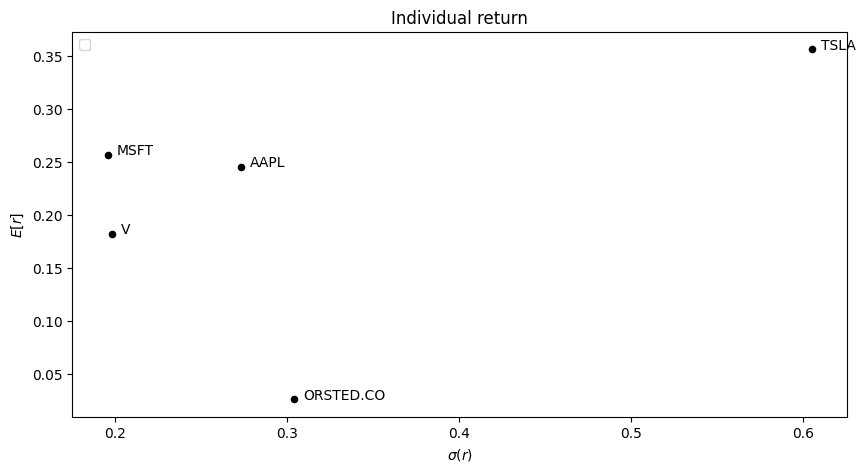

In [130]:
# Plot mean

plt.figure(1, figsize=(10,5))

# add single assets investment opportunities
plt.scatter(np.diag(Sigma)**0.5, mu[:], s=20, color='black')

for i in range(len(ticker)):
    plt.text((np.diag(Sigma)**0.5)[i] + 0.005, mu[i], ticker[i])

#descrive axis
plt.xlabel('$\sigma(r)$')
plt.ylabel('$E[r]$')

plt.legend()

#add a title
plt.title('Individual return')
plt.show()

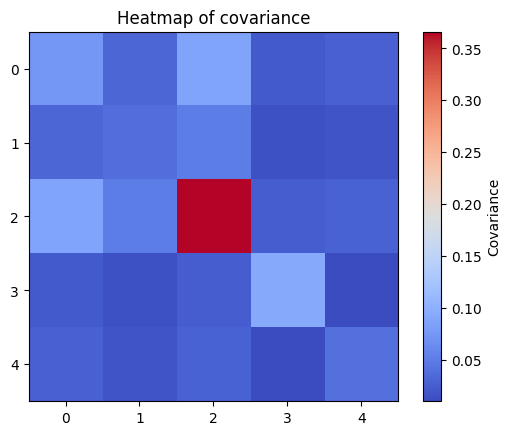

In [131]:
# Plot heatmap

plt.imshow(Sigma, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Covariance')
plt.title('Heatmap of covariance')
plt.xticks(np.arange(Sigma.shape[0]))
plt.yticks(np.arange(Sigma.shape[1]))
plt.show()

# Building the MV-Frontier

## 1. Unconstrained

In [132]:
#SINGLE OPTIMIZATIONS: Objective Function, Constraint Function, Starting Values, Bounds

def portfolio_variance(w):
        #input: w as numpy column vector
        #output: scalar
    return (w.T@Sigma@w).item() #objective function to be minimized


def eq_portfolio_return(w):
    #input: numpy portfolio column vector
    #note: mu_i is a global variable; needs to be known before calling this function
    #output: difference between w's expected return and the target return; scalar
    
    return (w.T@mu).item() - mu_i #constraint to meet target expected return mu_i


def eq_weight_sum(w): 
    #content: full investment constraint: 100% is invested in risky assets
    #input: numpy portfolio column vector
    #output: difference between sum of portfolio holdings and 100%=1. 
    
    return np.sum(w) - 1


# starting values
w0 = [0.2, 0.2, 0.2, 0.2, 0.2]

#no short-sale (bound) and minimum diversification bound
bounds = [(0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5)]


constraints = [{'type': 'eq', 'fun': eq_portfolio_return},
               {'type': 'eq', 'fun': eq_weight_sum}
               ] #target return and full investment constraint

In [133]:
#Loop through y-axis (i.e. mu_i)

mu_min = 0.01
mu_max = 1
incr = 0.001

In [134]:
#number of evaluations
nr_evals = int( (mu_max - mu_min) / incr + 1)
nr_evals #number of portfolios on the MV-frontier

991

In [135]:
# MV-Frontier

w_MV = np.zeros((nr_evals, 5))
mu_MV = np.zeros((nr_evals,))
sigma_MV = np.zeros((nr_evals,))

mu_i = mu_min
for i in range(0,nr_evals):
    w_opt = scipy.optimize.minimize(portfolio_variance, w0, constraints=constraints) # minimize variance for mu
    w_MV[i,:] = w_opt.x
    mu_MV[i] = (w_opt.x.T@mu).item() 
    sigma_MV[i] = (w_opt.x.T@Sigma@w_opt.x).item()**0.5
    
    mu_i = mu_i + incr

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_27188/2251878233.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(r)$')


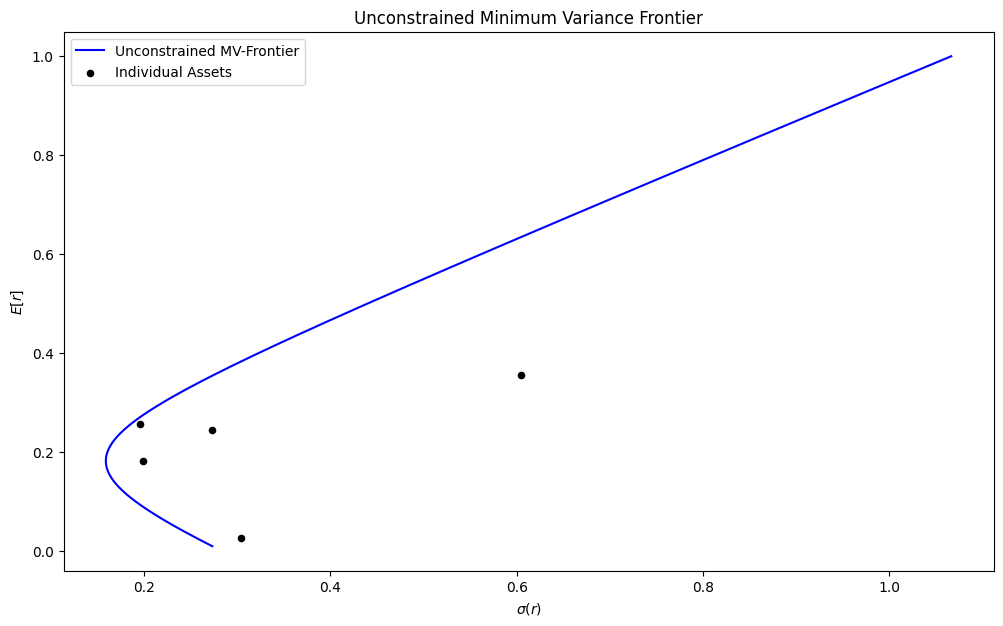

In [136]:
# Plot MV-Frontier

plt.figure(1, figsize=(12,7))

#show the MV-frontier that obeys constraints and bounds
plt.plot(sigma_MV, mu_MV, color='blue',label='Unconstrained MV-Frontier')

# add single assets investment opportunities
plt.scatter(np.diag(Sigma)**0.5, mu[:], s=20, color='black', label='Individual Assets')

#descrive axis
plt.xlabel('$\sigma(r)$')
plt.ylabel('$E[r]$')

plt.legend()

#add a title
plt.title('Unconstrained Minimum Variance Frontier')
plt.show()

## Constrained

In [137]:
#Loop through y-axis (i.e. mu_i)

mu_min = 0.01
mu_max = 1
incr = 0.001

In [138]:
#number of evaluations
nr_evals = int( (mu_max - mu_min) / incr + 1)
nr_evals #number of portfolios on the MV-frontier

991

In [139]:
# MV-Frontier

w_MV = np.zeros((nr_evals, 5))
mu_MV = np.zeros((nr_evals,))
sigma_MV = np.zeros((nr_evals,))

mu_i = mu_min
for i in range(0,nr_evals):
    w_opt = scipy.optimize.minimize(portfolio_variance, w0, bounds=bounds, constraints=constraints) # minimize variance for mu with bounds
    w_MV[i,:] = w_opt.x
    mu_MV[i] = (w_opt.x.T@mu).item()
    sigma_MV[i] = (w_opt.x.T@Sigma@w_opt.x).item()**0.5
    
    mu_i = mu_i + incr

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_27188/1086647150.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(r)$')


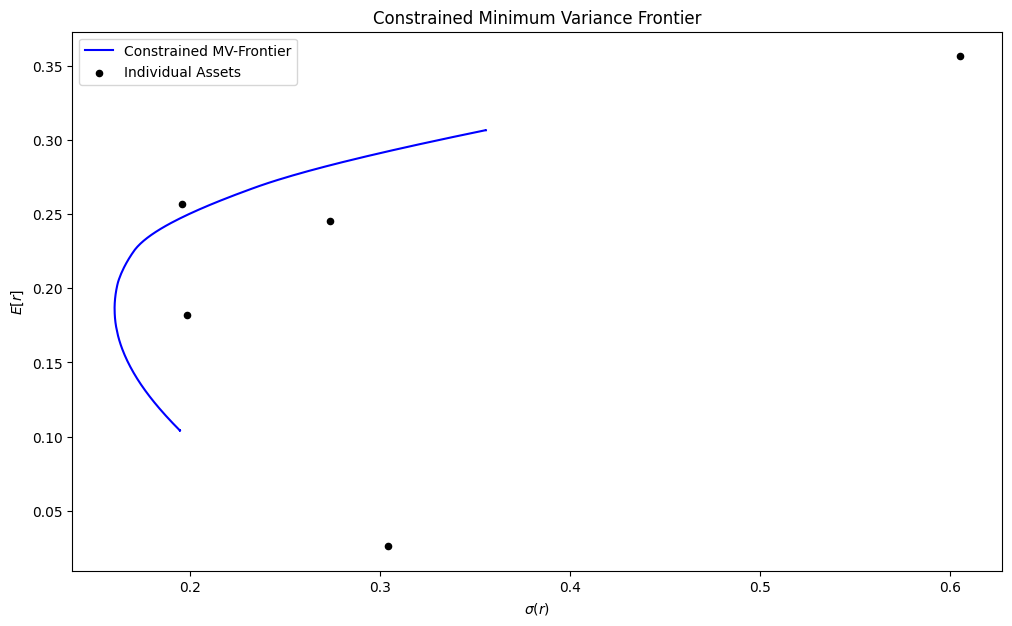

In [140]:
# Plot MV-Frontier

plt.figure(1, figsize=(12,7))

#show the MV-frontier that obeys constraints and bounds
plt.plot(sigma_MV, mu_MV, color='blue',label='Constrained MV-Frontier')

# add single assets investment opportunities
plt.scatter(np.diag(Sigma)**0.5, mu[:], s=20, color='black', label='Individual Assets')

#descrive axis
plt.xlabel('$\sigma(r)$')
plt.ylabel('$E[r]$')

plt.legend()

#add a title
plt.title('Constrained Minimum Variance Frontier')
plt.show()

# Tangency Portfolio

In [141]:
rf = 0.04146 # U.S. 1 Year Treasury

SR_MV = (mu_MV - rf) / sigma_MV

TP_index = np.argmax(SR_MV)

TP_index

222

In [158]:
w_TP = w_MV[TP_index]
w_TP

array([1.35503486e-01, 5.00000000e-01, 2.25491074e-02, 8.64670483e-18,
       3.41947407e-01])

In [143]:
mu_TP = mu_MV[TP_index]
mu_TP

0.231999999982429

In [144]:
sigma_TP = sigma_MV[TP_index]
sigma_TP

0.17543526125244424

In [145]:
SR_TP = (mu_TP - rf) / sigma_TP
SR_TP

1.0860986475703402

# Optimal Complete Portfolio

In [146]:
A = 8 # risk aversion on (1-10) scale

y = (mu_TP - rf) / (A * (sigma_TP ** 2))

y

0.773859998138778

In [147]:
# calculate utility

mu_C = y*mu_TP+(1-y)*rf 

sigma_C = y*sigma_TP

utility_C = mu_C - 0.5*A*(sigma_C**2)

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_27188/3474145562.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(r)$')


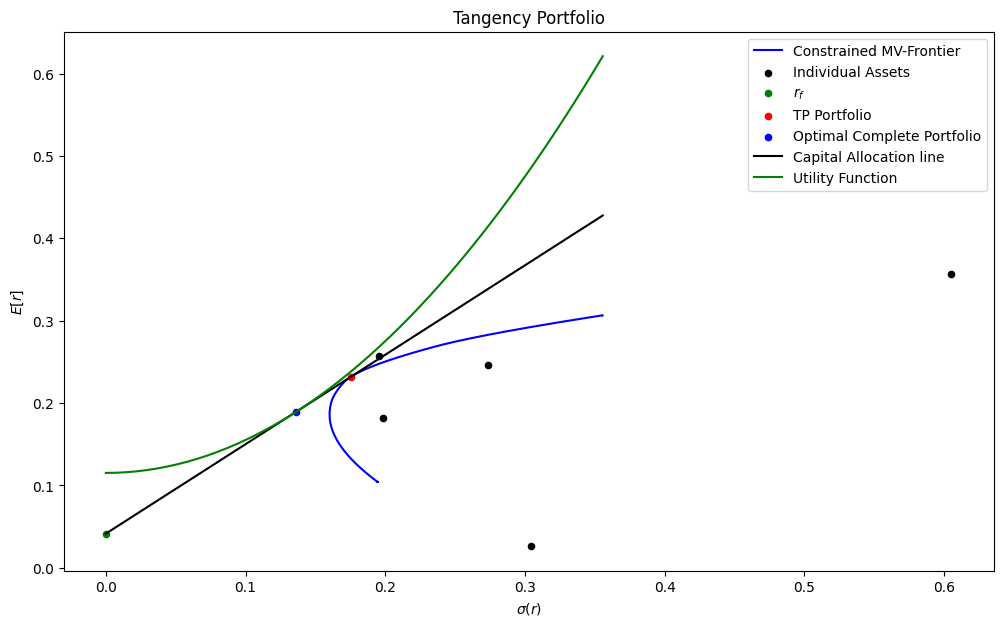

In [148]:
# Plot Tangency Portfolio

plt.figure(1, figsize=(12,7))

#show the MV-frontier that obeys constraints and bounds
plt.plot(sigma_MV, mu_MV, color='blue',label='Constrained MV-Frontier')

# add single assets investment opportunities and risk-free asset
plt.scatter(np.diag(Sigma)**0.5, mu, s=20, color='black', label='Individual Assets')
plt.scatter([0], [rf], s = 20, color='green', label='$r_f$')
plt.scatter(sigma_TP, mu_TP, s = 20, color='red', label='TP Portfolio')
plt.scatter(sigma_C, mu_C, s = 20, color='blue', label='Optimal Complete Portfolio')

# add capital market line
x = np.linspace(0, np.max(sigma_MV))
y = rf + SR_TP * x
plt.plot(x, y, color='black', label='Capital Allocation line')

# add utility function
x = np.linspace(0, np.max(sigma_MV))
y = utility_C + 0.5*A*(x**2)
plt.plot(x, y, color='green', label='Utility Function')

#descrive axis
plt.xlabel('$\sigma(r)$')
plt.ylabel('$E[r]$')


plt.legend()

#add a title
plt.title('Tangency Portfolio')
plt.show()

# Decomposing expected portfolio performance (return and risk) into systematic ans idiosyncratic components

In [149]:
# calculate SP500 log-return
data['logreturn_^GSPC'] = np.log(data['^GSPC']) - np.log(data['^GSPC'].shift(1))

In [150]:
# drop nan
data = data.dropna()

In [151]:
# risk free return rate per month
rf_monthly = rf / 12

rf_monthly

0.0034549999999999997

In [152]:
# calculate OLS Model for each stock

betas = []
alphas = []

for i in range(len(ticker)):
    y = data["logreturn_" + ticker[i]] - rf_monthly # monthly stock excess reuturn
    X = data['logreturn_^GSPC'] - rf_monthly # monthly market excess return
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    betas.append(model.params.iloc[1])
    alphas.append(model.params.iloc[0]* 12) # annualized alpha
    print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         logreturn_AAPL   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     79.13
Date:                Sun, 25 May 2025   Prob (F-statistic):           1.96e-14
Time:                        19:33:58   Log-Likelihood:                 149.10
No. Observations:                 106   AIC:                            -294.2
Df Residuals:                     104   BIC:                            -288.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0097      0.006     

In [153]:
# Portfolio decomposition
portfolio_beta = np.sum(np.array(betas) * w_TP)
portfolio_alpha = np.sum(np.array(alphas) * w_TP)
systematic_var = portfolio_beta**2 * np.var(data['logreturn_^GSPC']) * 12

idiosyncratic_var = sigma_TP - systematic_var

print ( f" Portfolio Beta : { portfolio_beta :.4f}")
print ( f" Portfolio Alpha : { portfolio_alpha :.4f}")
print ( f" Systematic Variance : { systematic_var :.6f}")
print ( f" Idiosyncratic Variance : { idiosyncratic_var :.6f}")

 Portfolio Beta : 0.9540
 Portfolio Alpha : 0.1169
 Systematic Variance : 0.022175
 Idiosyncratic Variance : 0.153260


# Expected vs. Realized Performance

In [154]:
# build train and test data set
train_data = data.iloc[:int(len(data) * 0.7)][['logreturn_AAPL', 'logreturn_MSFT', 'logreturn_TSLA', 'logreturn_ORSTED.CO', 'logreturn_V']] # use first 70%
test_data = data.iloc[-int(len(data) * 0.3):][['logreturn_AAPL', 'logreturn_MSFT', 'logreturn_TSLA', 'logreturn_ORSTED.CO', 'logreturn_V']] # use last 30%

In [155]:
# calculate expected performance
mean_train_data = train_data.mean() * 12
sigma_train_data = train_data.cov() * 12

exp_return = np.sum(mean_train_data * w_TP)
exp_vol = np.sqrt(w_TP @ sigma_train_data @ w_TP)

In [156]:
# calculate realized performance

realized_returns = np.sum(test_data * w_TP, axis=1)
realized_return = realized_returns.mean() * 12
realized_vol = realized_returns.std() * np.sqrt(12)

In [157]:
print(f" Expected Return : { exp_return :.4f} , Realized Return :{ realized_return :.4f}")

print(f" Expected Volatility : { exp_vol :.4f} , Realized Volatility :{ realized_vol :.4f}")

 Expected Return : 0.2186 , Realized Return :0.2231
 Expected Volatility : 0.1857 , Realized Volatility :0.1501
